## Implementing Autoencoders and Variational Autoencoder using Keras

In this lab lesson, we will look into the implementation of Autoencoders (AE) and Variational Autoencoder (VAE) using Keras. The tutorial is based on the code provided by https://blog.keras.io/building-autoencoders-in-keras.html, and https://keras.io/examples/generative/vae.

## Load MNIST Dataset
Load MNIST dataset from keras.datasets

In [1]:
import keras
from keras import layers
from keras import ops
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from matplotlib.cm import get_cmap

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print("=============================================================")
print("Before Conversion:")
print(x_train.shape)
print(x_test.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print("=============================================================")
print("After Conversion:")
print(x_train.shape)
print(x_test.shape)
print("=============================================================")

Before Conversion:
(60000, 28, 28)
(10000, 28, 28)
After Conversion:
(60000, 784)
(10000, 784)


## Helper Functions
Defining helper functions to plot the results

In [2]:
#Function to plot loss and accuracy curves
def plot_curve(log, valid=True):
    N_train = len(log.history['loss'])
    if valid:
      N_valid = len(log.history['val_loss'])

    plt.figure(figsize=(18,4))

    # Plot loss on training and validation set
    plt.plot(log.history['loss'])

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid('on')
    if valid:
      plt.plot(np.linspace(0,N_train-1,N_valid), log.history['val_loss'])
      plt.legend(['Train', 'Validation'])
    plt.show()

def pred(imgs):
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 2))
    for i in range(n):

        # Display reconstruction
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def denoise_pred(imgs):
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def cifar(x,y):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(y[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def plot_label_clusters(model, data, labels, vae=False):
    # display a 2D plot of the digit classes in the latent space
    if vae:
      z_mean, _, _ = model.encoder.predict(data, verbose=0)
    else:
      z_mean = model.predict(data, verbose=0)

    cmap = get_cmap("tab10")  # Colormap for up to 10 discrete classes

    plt.figure(figsize=(12, 10))
    for digit in range(10):
        mask = labels == digit
        plt.scatter(
            z_mean[mask, 0], z_mean[mask, 1],
            label=f"{digit}",  # Show digit in the legend
            color=cmap(digit),
            alpha=0.7
        )

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.legend(loc="best", title="Digits", fontsize='medium')
    plt.grid(True)
    plt.show()


## 1. Autoencoder

### 1.1 Model Definition

In [4]:
#define encoder network
encoder = keras.Sequential(name='Encoder')
encoder.add(layers.Dense(128, activation='relu',input_shape=(784,),name='Encoder_Layer1'))
encoder.add(layers.Dense(64, activation='relu',name='Encoder_Layer2'))
encoder.add(layers.Dense(2, activation='relu',name='Encoder_Layer3'))
encoder.summary()

#define decoder network
decoder = keras.Sequential(name='Decoder')
decoder.add(layers.Dense(64, activation='relu', input_shape=(2,),name='Decoder_Layer1'))
decoder.add(layers.Dense(128, activation='relu',name='Decoder_Layer2'))
decoder.add(layers.Dense(784, activation='relu',name='Output')) #kan va sigmoid
decoder.summary()

#define autoencoder by combining encoder and decoder
input_img = keras.Input(shape=(784,),name='Input_Layer')
z = encoder(input_img)
output_img = decoder(z)
autoencoder = keras.models.Model(inputs=input_img, outputs=output_img, name='Autoencoder')
autoencoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_Layer1 (Dense)          │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Layer2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Layer3 (Dense)          │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,866 (425.26 KB)

 Trainable params: 108,866 (425.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Decoder_Layer1 (Dense)          │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Layer2 (Dense)          │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,648 (428.31 KB)

 Trainable params: 109,648 (428.31 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Sequential)            │ (None, 2)              │       108,866 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ (None, 784)            │       109,648 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,514 (853.57 KB)

 Trainable params: 218,514 (853.57 KB)

 Non-trainable params: 0 (0.00 B)

### 1.2 Model Training

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0813 - val_loss: 0.0626
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0614 - val_loss: 0.0585
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0581 - val_loss: 0.0556
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0551 - val_loss: 0.0533
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0529 - val_loss: 0.0511
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0508 - val_loss: 0.0496
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0489 - val_loss: 0.0480
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0481 - val_loss: 0.0471
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0469 - val_loss: 0.0467
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0466 - val_loss: 0.0462
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0459 - val_loss: 0.0458
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 

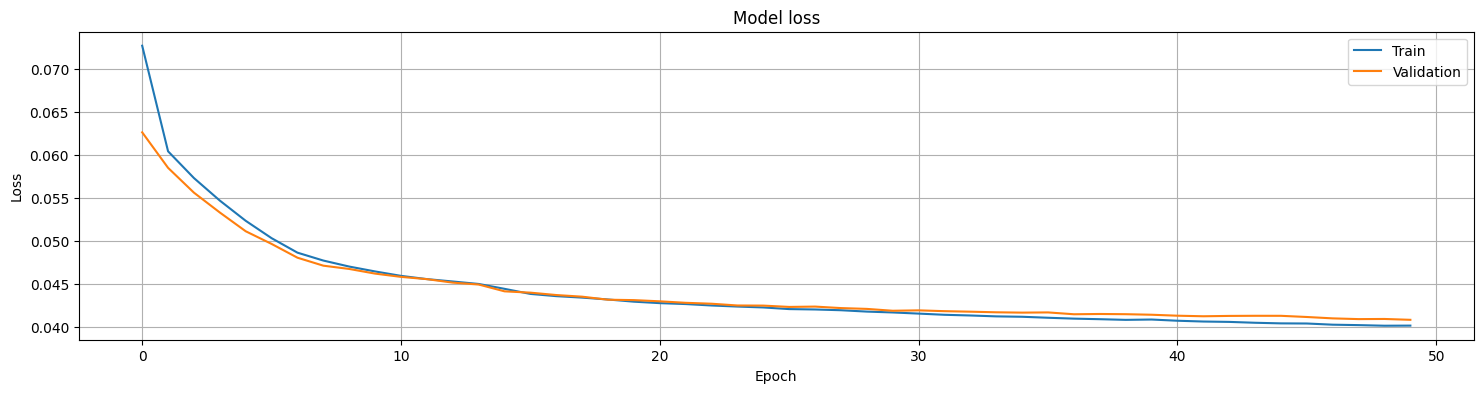

In [5]:
#Configure the model for training
autoencoder.compile(optimizer='adam', loss='mse')

#Model Training
log = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

#Plot loss curves
plot_curve(log)

### 1.3 Display Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


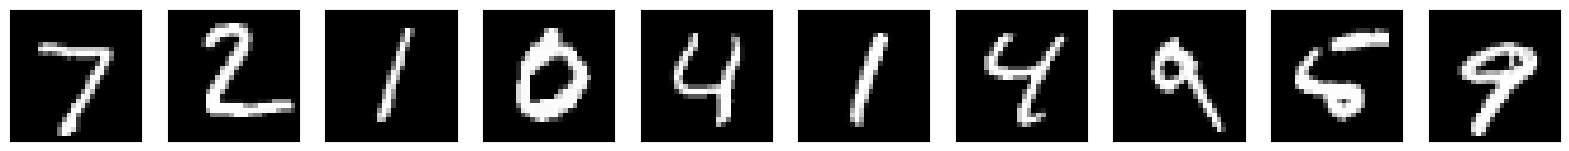

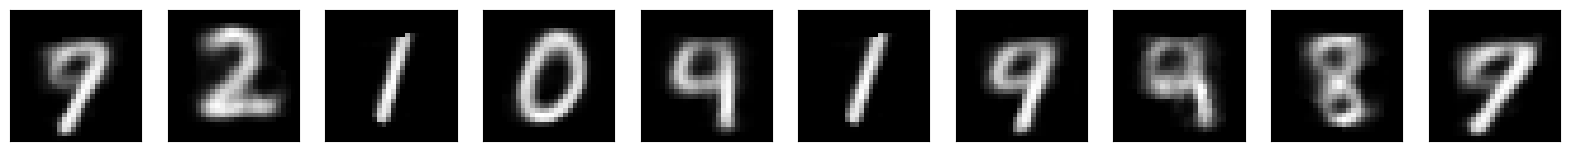

In [42]:
test = autoencoder.predict(x_test)
pred(x_test)
pred(test)

### 1.4 Reconstruction with AE

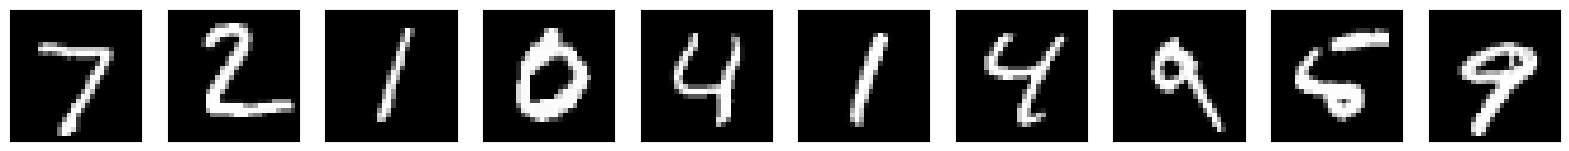

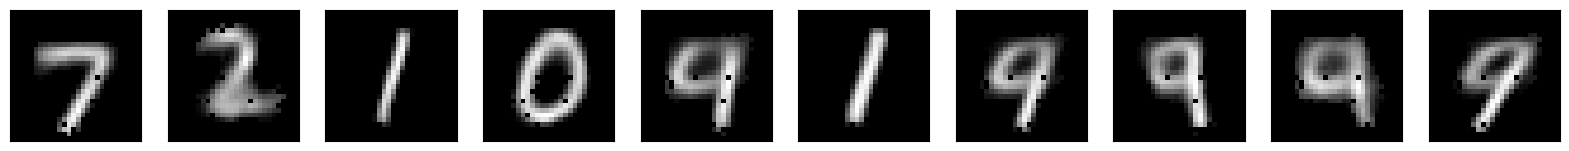

In [6]:
#Get the encoded values for test images
latent_z = encoder(x_test)

#Get the decoded images from the encoded values
decoded_img = decoder(latent_z)

#Plot test and decoded images
pred(x_test)
pred(decoded_img.numpy())

### 1.5 Interpolation with AE

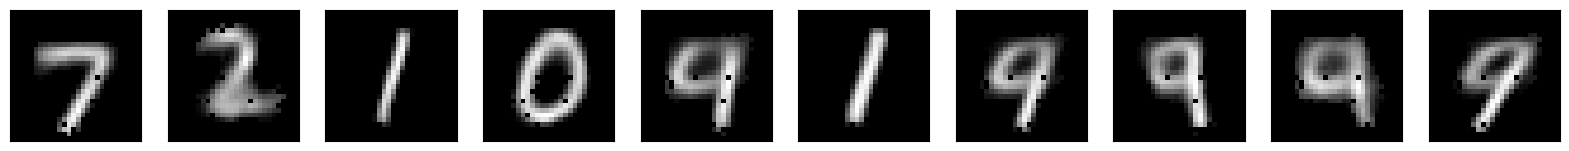

Start interpolation


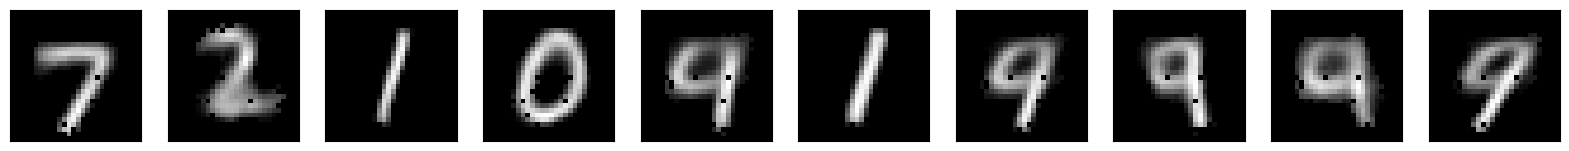

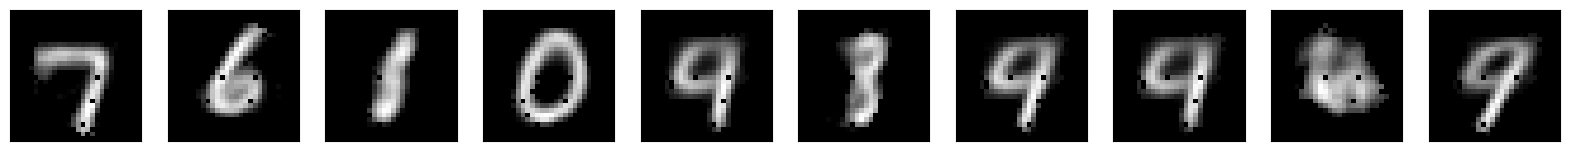

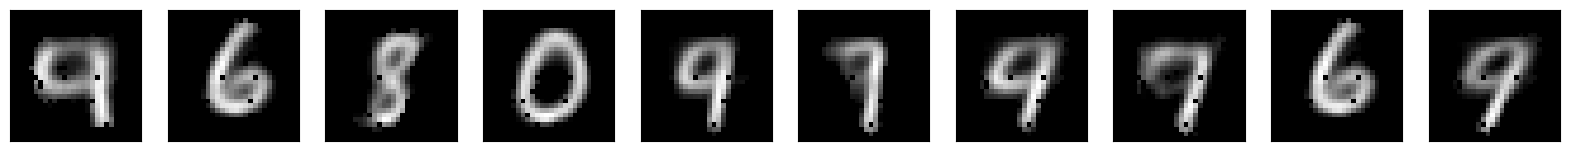

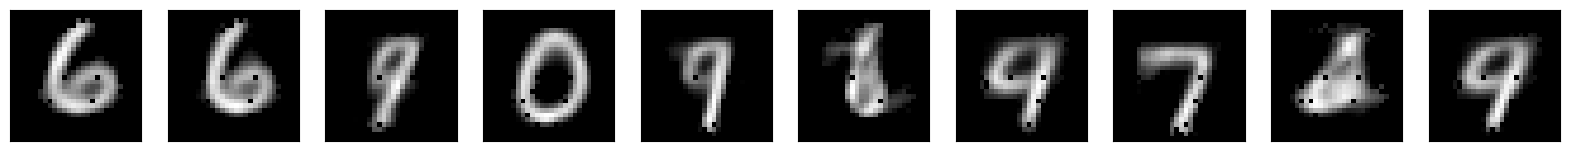

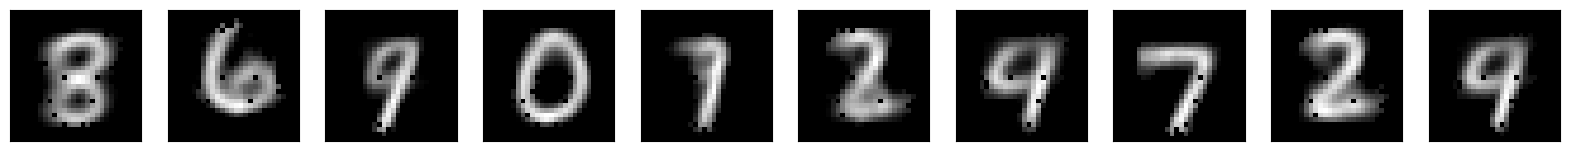

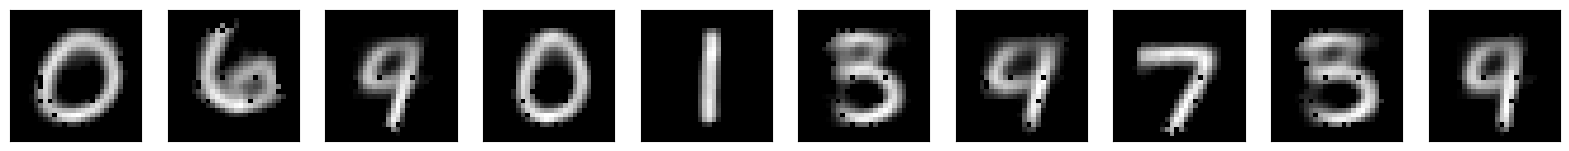

In [8]:
#Get the encoded values for test images
latent_z1 = encoder(x_test[:10, :])
latent_z2 = encoder(x_test[10:20, :])

#Get the decoded images from the encoded values
decoded_img1 = decoder(latent_z1)
decoded_img2 = decoder(latent_z2)

#Plot test and decoded images
pred(decoded_img1.numpy())

#Plot more
print('Start interpolation')
for alpha in range(5):
  alpha = 0.2 * alpha
  latent_new = (1 - alpha) * latent_z1 + alpha * latent_z2
  decoded_imgnew = decoder(latent_new)
  pred(decoded_imgnew.numpy())

pred(decoded_img2.numpy())

### 1.6 Sampling with AE

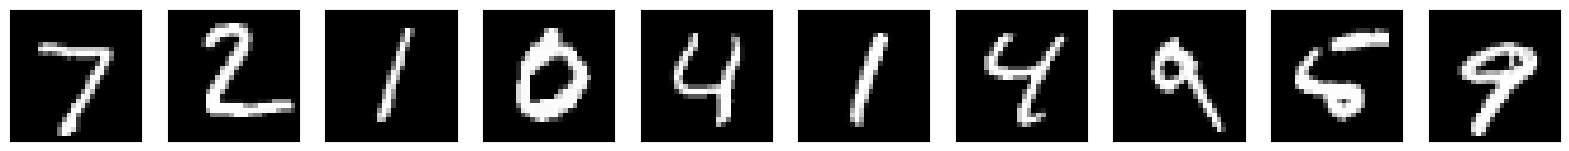

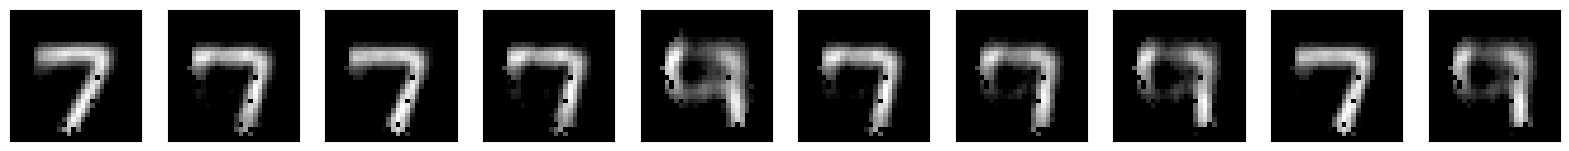

In [30]:
import tensorflow_probability as tfp

tfd = tfp.distributions
dist = tfd.Normal(loc=[15, 20], scale=1)

#Get the encoded values for test images
latent_z = encoder(x_test)

#sample z~p(z)
epsilon = dist.sample([10])

# x~p(x|z)
decoded_from_noise = decoder(epsilon)

#Plot test and decoded images
pred(x_test)
pred(decoded_from_noise.numpy())


C:\Users\david\AppData\Local\Temp\ipykernel_2284\2483001453.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")  # Colormap for up to 10 discrete classes


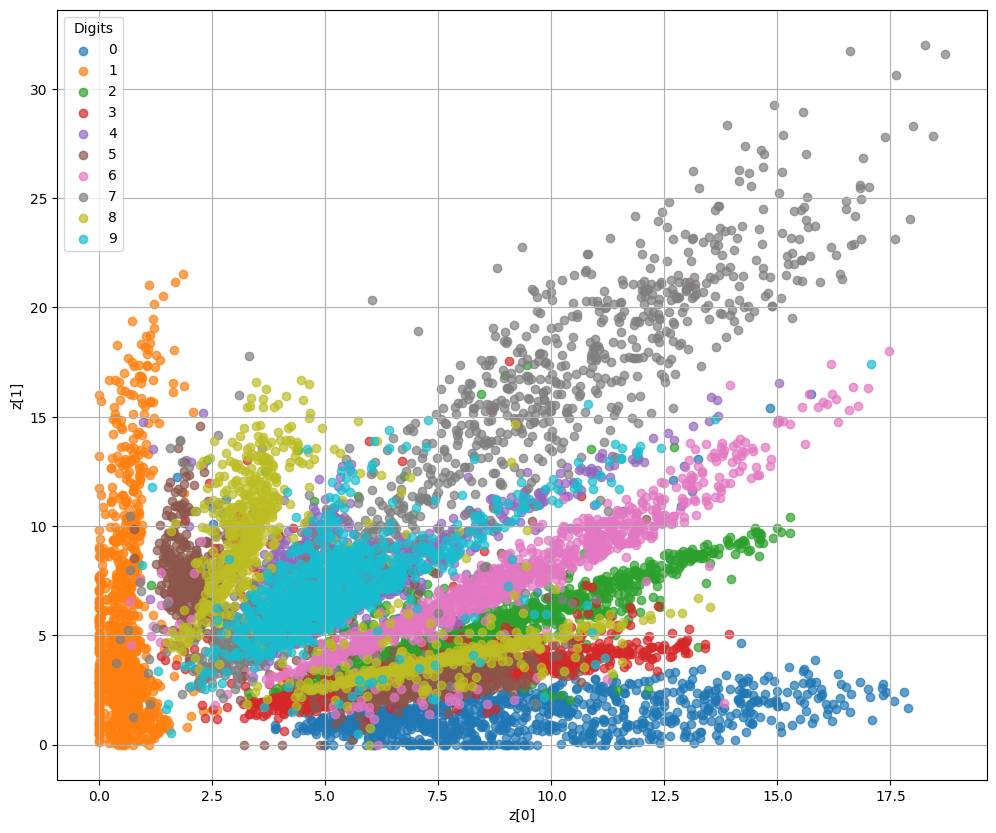

In [13]:
plot_label_clusters(encoder, x_test, y_test, vae=False)

# Variational AutoEncoder (VAE)

### 2.1 Re-parameterization trick

In [31]:
# https://keras.io/examples/generative/vae/
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [32]:
# VAE encoder
encoder_inputs = keras.Input(shape=(784,),name='EncoderInput')
x = layers.Dense(128, activation='relu',input_shape=(784,),name='Encoder_Layer1')(encoder_inputs)
x = layers.Dense(64, activation='relu',name='Encoder_Layer2')(x)
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
vae_encoder.summary()

# VAE decoder, indentical to AE decoder
vae_decoder = keras.Sequential(name='Decoder')
vae_decoder.add(layers.Dense(64, activation='relu', input_shape=(2,),name='Decoder_Layer1'))
vae_decoder.add(layers.Dense(128, activation='relu',name='Decoder_Layer2'))
vae_decoder.add(layers.Dense(784, activation='sigmoid',name='Output'))
vae_decoder.summary()

c:\Users\david\Documents\GitHub\TNM112\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput        │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Layer1      │ (None, 128)       │    100,480 │ EncoderInput[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Layer2      │ (None, 64)        │      8,256 │ Encoder_Layer1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        130 │ Encoder_Layer2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        130 │ Encoder_Layer2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 108,996 (425.77 KB)

 Trainable params: 108,996 (425.77 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Decoder_Layer1 (Dense)          │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Layer2 (Dense)          │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,648 (428.31 KB)

 Trainable params: 109,648 (428.31 KB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Define VAE loss

In [34]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss =  ops.mean(
                 ops.sum(
                    ops.square(data-reconstruction),
                 axis=1)
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - kl_loss: 5.3370 - loss: 85.0562 - reconstruction_loss: 79.7192
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - kl_loss: 2.4485 - loss: 45.9666 - reconstruction_loss: 43.5181
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - kl_loss: 2.9237 - loss: 44.0722 - reconstruction_loss: 41.1486
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - kl_loss: 3.1631 - loss: 43.1070 - reconstruction_loss: 39.9439
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - kl_loss: 3.3139 - loss: 42.3608 - reconstruction_loss: 39.0468
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - kl_loss: 3.4782 - loss: 41.8090 - reconstruction_loss: 38.3308
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - kl_loss: 3.6115 - loss: 41.2103 - reconstruction_loss: 37.5988
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - kl_loss: 3.7135 - loss: 40.7732 - reconstruction_loss: 37.0597
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - 

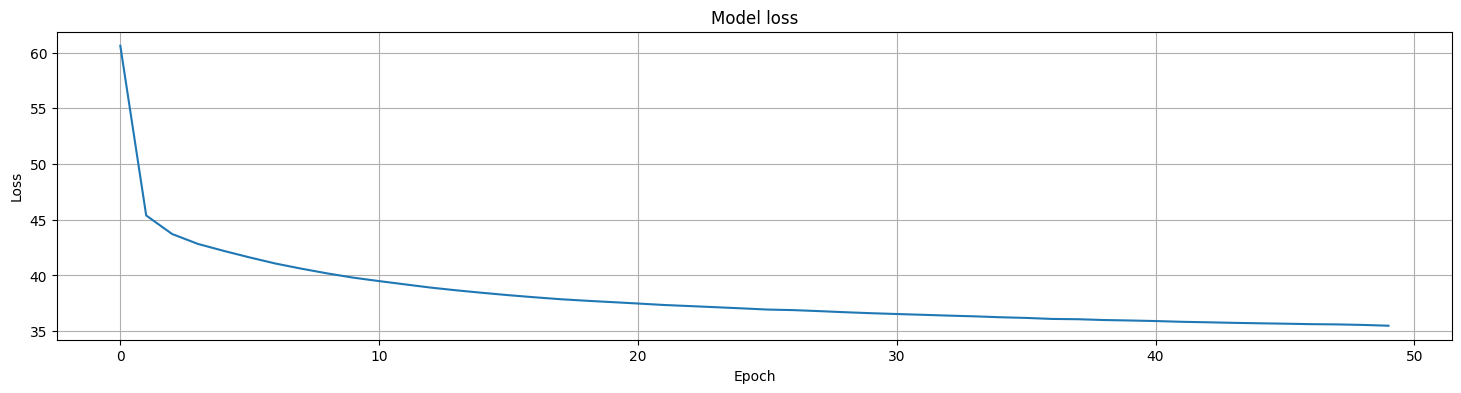

In [35]:
vae = VAE(vae_encoder, vae_decoder)
vae.compile(optimizer=keras.optimizers.Adam())
log = vae.fit(x_train, epochs=50, batch_size=256, shuffle=True)
#Plot loss curves
plot_curve(log, valid=False)

tf.Tensor(
[0.13120775 0.14641142 0.10122488 0.06938952 0.08355002 0.09911244
 0.10460868 0.13827315 0.06921726 0.06428115], shape=(10,), dtype=float32)


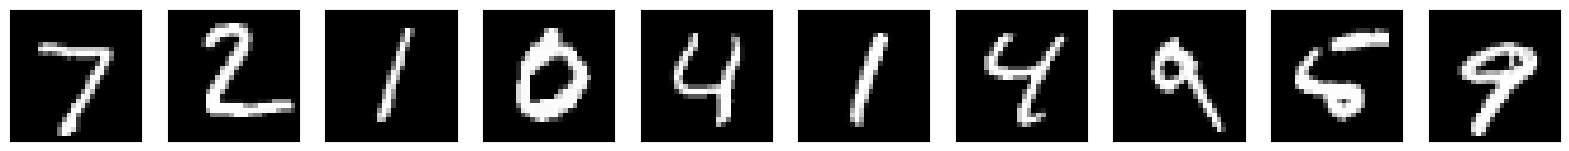

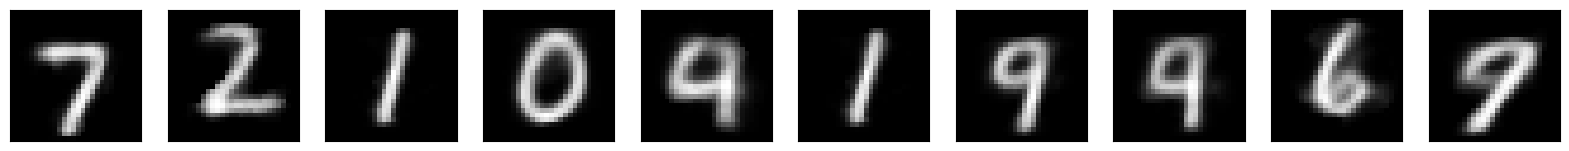

In [37]:
#Get the encoded values for test images
z_mean, z_log_var, latent_z = vae_encoder(x_test[:10, :])

print(ops.mean(ops.exp(0.5 * z_log_var), axis=-1))
#Get the decoded images from the encoded values
decoded_img = vae_decoder(latent_z)

#Plot test and decoded images
pred(x_test)
pred(decoded_img.numpy())

In [39]:
#Get the encoded values for test images
z_mean1, z_log_var1, latent_z1 = vae_encoder(x_test[:10, :])
z_mean2, z_log_var2, latent_z2= vae_encoder(x_test[10:20, :])

#Get the decoded images from the encoded values
decoded_img1 = vae_decoder(latent_z1)
decoded_img2 = vae_decoder(latent_z2)

#Plot test and decoded images
pred(decoded_img1.numpy())

#Plot more
print('Start interpolation')
for alpha in range(5):
  alpha = 0.2 * alpha
  latent_new = (1 - alpha) * latent_z1 + alpha * latent_z2
  decoded_imgnew = vae_decoder(latent_new)
  pred(decoded_imgnew.numpy())

pred(decoded_img2.numpy())

ValueError: Input 0 of layer "encoder" is incompatible with the layer: expected shape=(None, 784), found shape=(10, 28, 28)

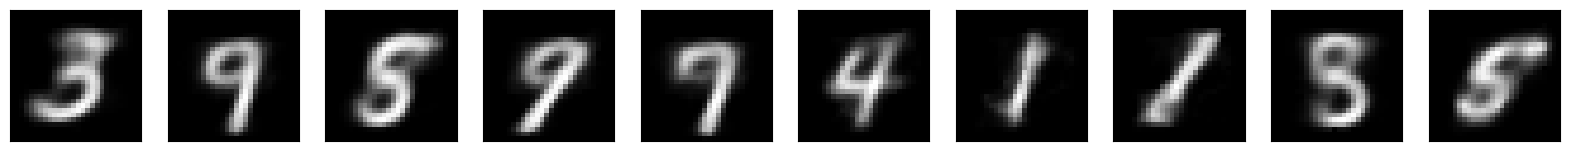

In [40]:
# define standard gaussian
tfd = tfp.distributions
dist_vae = tfd.Normal(loc=0., scale=1)
# sample from gaussian z~p(z)
latent_z = dist_vae.sample([10,2])
# x~p(x|z)
imgs_samples = vae_decoder(latent_z)
pred(imgs_samples.numpy())

In [41]:
plot_label_clusters(vae, x_test, y_test, vae=True)

ValueError: Input 0 of layer "encoder" is incompatible with the layer: expected shape=(None, 784), found shape=(32, 28, 28)

## 3. Autoencoder using CNN

### 3.1 Reshaping data

In [43]:
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### 3.2 Model Definition

In [42]:
#define encoder network
encoder_cnn = keras.Sequential(name='Encoder_CNN')
encoder_cnn.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(28,28,1), name='E1'))
encoder_cnn.add(layers.MaxPooling2D((2, 2), padding='same', name='E2'))
encoder_cnn.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='E3'))
encoder_cnn.add(layers.MaxPooling2D((2, 2), padding='same', name='E4'))
encoder_cnn.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='E5'))
encoder_cnn.add(layers.MaxPooling2D((2, 2), padding='same', name='E6'))
encoder_cnn.add(layers.Flatten(name='E7'))
encoder_cnn.add(layers.Dense(128, activation='relu',name='E8'))
encoder_cnn.summary()

#define decoder network
decoder_cnn = keras.Sequential(name='Decoder_CNN')
decoder_cnn.add(layers.Dense(256, input_shape=(128,), activation='relu',name='D1'))
decoder_cnn.add(layers.Reshape((4,4,16),name='D2'))
decoder_cnn.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='D3'))
decoder_cnn.add(layers.UpSampling2D((2, 2), name='D4'))
decoder_cnn.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='D5'))
decoder_cnn.add(layers.UpSampling2D((2, 2), name='D6'))
decoder_cnn.add(layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', name='D7'))
decoder_cnn.add(layers.UpSampling2D((2, 2), name='D8'))
decoder_cnn.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Output'))
decoder_cnn.summary()

#define autoencoder by combining encoder and decoder
input_img = keras.Input(shape=(28,28,1), name='Input_Layer')
z = encoder_cnn(input_img)
output_img = decoder_cnn(z)
autoencoder_cnn = keras.models.Model(inputs=input_img, outputs=output_img, name='Autoencoder_CNN')
autoencoder_cnn.summary()

c:\Users\david\Documents\GitHub\TNM112\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Encoder_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ E1 (Conv2D)                     │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ E2 (MaxPooling2D)               │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ E3 (Conv2D)                     │ (None, 14, 14, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ E4 (MaxPooling2D)               │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ E5 (Conv2D)                     │ (None, 7, 7, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ E6 (MaxPooling2D)               │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ E7 (Flatten)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ E8 (Dense)                      │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,728 (135.66 KB)

 Trainable params: 34,728 (135.66 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ D1 (Dense)                      │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D2 (Reshape)                    │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D3 (Conv2D)                     │ (None, 4, 4, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D4 (UpSampling2D)               │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D5 (Conv2D)                     │ (None, 8, 8, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D6 (UpSampling2D)               │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D7 (Conv2D)                     │ (None, 14, 14, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D8 (UpSampling2D)               │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Conv2D)                 │ (None, 28, 28, 1)      │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,161 (145.16 KB)

 Trainable params: 37,161 (145.16 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Autoencoder_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_CNN (Sequential)        │ (None, 128)            │        34,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_CNN (Sequential)        │ (None, 28, 28, 1)      │        37,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,889 (280.82 KB)

 Trainable params: 71,889 (280.82 KB)

 Non-trainable params: 0 (0.00 B)

### 2.3 Model Training

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.2702 - val_loss: 0.1463
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.1393 - val_loss: 0.1267
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.1240 - val_loss: 0.1183
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.1159 - val_loss: 0.1129
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.1112 - val_loss: 0.1091
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.1074 - val_loss: 0.1074
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.1047 - val_loss: 0.1046
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.1028 - val_loss: 0.1022
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.1008 - val_loss: 0.1016
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0995 - val_loss: 0.0986
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0981 - val_loss: 0.0981
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━

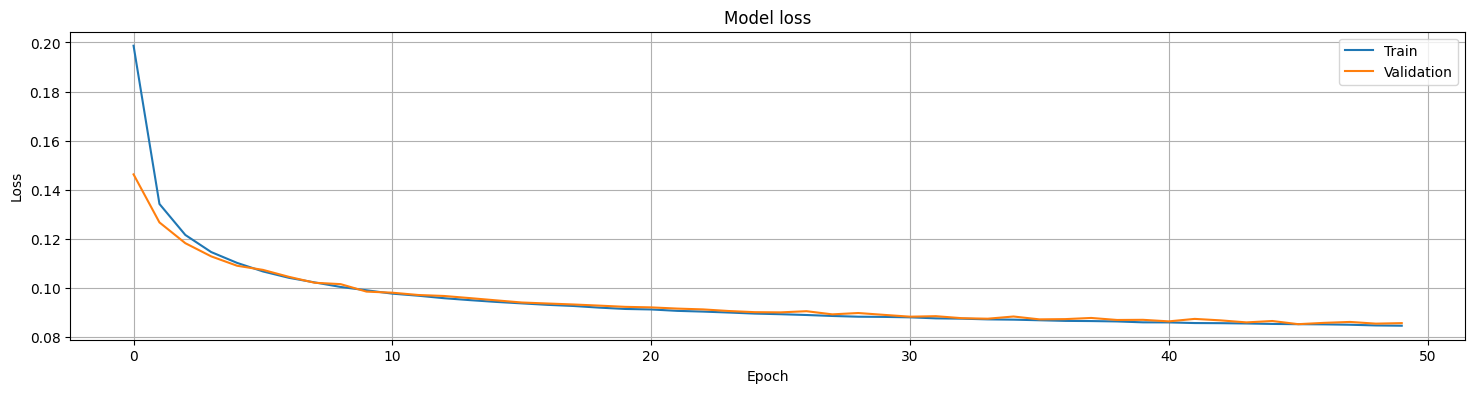

In [44]:
#Configure the model for training
autoencoder_cnn.compile(optimizer='adam', loss='binary_crossentropy')

#Model Training
log = autoencoder_cnn.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_split=0.2)

#Plot loss curves
plot_curve(log)

### 2.4 Display Results

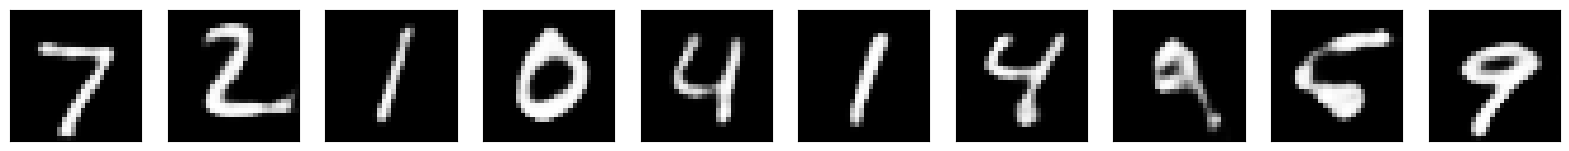

In [46]:
#Get the encoded values for test images
encoded_img = encoder_cnn(x_test)

#Get the decoded images from the encoded values
decoded_img = decoder_cnn(encoded_img)

#Plot test and decoded images
pred(decoded_img.numpy())

## 3. Autoencoder using Transposed Convolution

### 3.1 Model Definition

In [50]:
#define encoder network
encodertc = keras.Sequential(name='Encoder_CNN')
encodertc.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(28,28,1), name='E1'))
encodertc.add(layers.MaxPooling2D((2, 2), padding='same', name='E2'))
encodertc.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='E3'))
encodertc.add(layers.MaxPooling2D((2, 2), padding='same', name='E4'))
#flatten
#dense
encodertc.summary()

#define decoder network
decodertc = keras.Sequential(name='Decoder_Transpose_Conv')
#dense
#reshape
decodertc.add(layers.Conv2DTranspose(32, (3, 3), input_shape=(7,7,32),activation='relu', padding='same',
                                    strides=2, kernel_initializer='he_normal', name='D1'))
decodertc.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same',
                                    strides=2, kernel_initializer='he_normal', name='D2'))
decodertc.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Output'))
decodertc.summary()

#define autoencoder by combining encoder and decoder
input_img = keras.Input(shape=(28,28,1), name='Input_Layer')
z = encodertc(input_img)
output_img = decodertc(z)
autoencodertc = keras.models.Model(inputs=input_img, outputs=output_img, name='Fully_Convolutional_Autoencoder')
autoencodertc.summary()

c:\Users\david\Documents\GitHub\TNM112\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Encoder_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ E1 (Conv2D)                     │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ E2 (MaxPooling2D)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ E3 (Conv2D)                     │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ E4 (MaxPooling2D)               │ (None, 7, 7, 32)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,568 (37.38 KB)

 Trainable params: 9,568 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

c:\Users\david\Documents\GitHub\TNM112\venv\lib\site-packages\keras\src\layers\convolutional\base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "Decoder_Transpose_Conv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ D1 (Conv2DTranspose)            │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D2 (Conv2DTranspose)            │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Conv2D)                 │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,785 (73.38 KB)

 Trainable params: 18,785 (73.38 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Fully_Convolutional_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_CNN (Sequential)        │ (None, 7, 7, 32)       │         9,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Transpose_Conv          │ (None, 28, 28, 1)      │        18,785 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Model Training

In [51]:
#Configure the model for training
autoencoder_tcnn.compile(optimizer='adam', loss='mse')

#Model Training
log = autoencoder_tcnn.fit(x_train, x_train, epochs=5, batch_size=128, shuffle=True, validation_split=0.2)

#Plot loss curves
plot_curve(log)

NameError: name 'autoencoder_tcnn' is not defined

### 3.3 Display Results

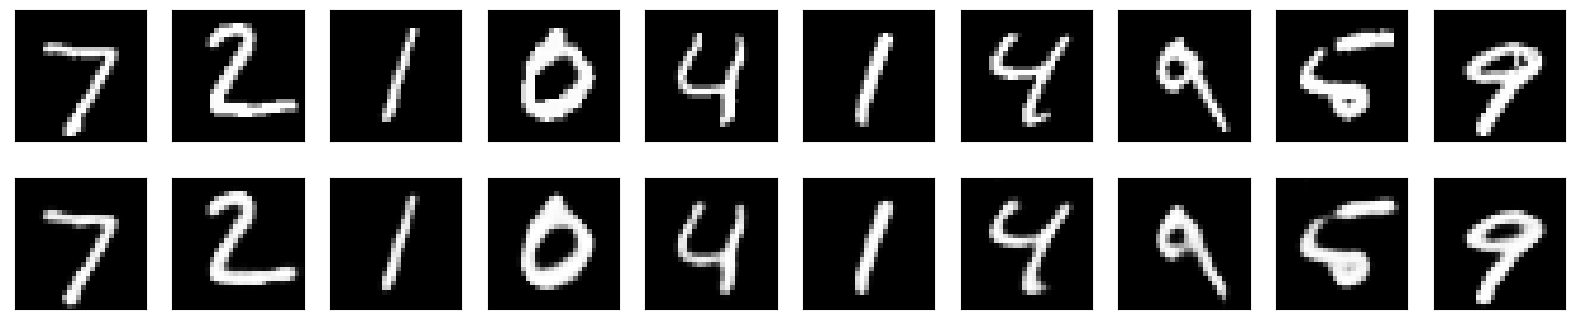

In [ ]:
#Get the encoded values for test images
encoded_img = encoder_tc(x_test)

#Get the decoded images from the encoded values
decoded_img = decoder_tc(encoded_img)

#Plot test and decoded images
pred(decoded_img.numpy())

## 4. Image Denoising using Fully Convolutional Autoencoder

### 4.1 Preparing Noisy Data

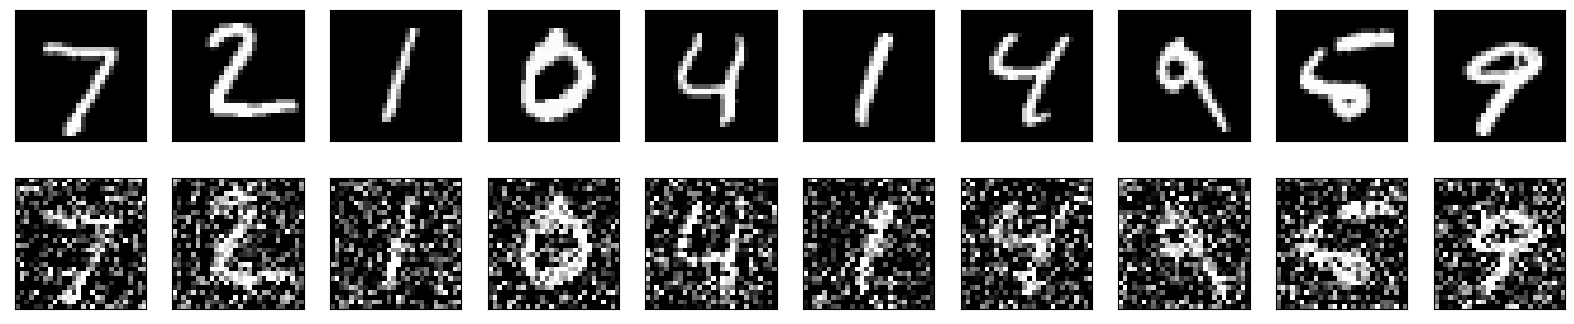

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

pred(x_test_noisy)

### 4.2 Model Definition

In [ ]:
#define encoder network
encoder1 = keras.Sequential(name='Encoder_CNN')
encoder1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28,28,1), name='E1'))
encoder1.add(layers.MaxPooling2D((2, 2), padding='same', name='E2'))
encoder1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='E3'))
encoder1.add(layers.MaxPooling2D((2, 2), padding='same', name='E4'))
encoder1.summary()

#define decoder network
decoder1 = keras.Sequential(name='Decoder_CNN')
decoder1.add(layers.Conv2DTranspose(32, (3, 3), input_shape=(7,7,32),activation='relu', padding='same',
                                    strides=2, name='D1'))
decoder1.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same',
                                    strides=2, name='D2'))
decoder1.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Output'))
decoder1.summary()

#define autoencoder by combining encoder and decoder
input_img = keras.Input(shape=(28,28,1), name='Input_Layer')
z = encoder1(input_img)
output_img = decoder1(z)
autoencoder1 = keras.models.Model(inputs=input_img, outputs=output_img, name='Fully_Convolutional_Autoencoder')
autoencoder1.summary()

Model: "Encoder_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 E1 (Conv2D)                 (None, 28, 28, 32)        320       
                                                                 
 E2 (MaxPooling2D)           (None, 14, 14, 32)        0         
                                                                 
 E3 (Conv2D)                 (None, 14, 14, 32)        9248      
                                                                 
 E4 (MaxPooling2D)           (None, 7, 7, 32)          0         
                                                                 
Total params: 9568 (37.38 KB)
Trainable params: 9568 (37.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Decoder_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


### 4.3 Model Training

Epoch 1/100
422/422 [==============================] - 9s 19ms/step - loss: 0.1980 - val_loss: 0.1241
Epoch 2/100
422/422 [==============================] - 8s 19ms/step - loss: 0.1167 - val_loss: 0.1131
Epoch 3/100
422/422 [==============================] - 8s 19ms/step - loss: 0.1104 - val_loss: 0.1095
Epoch 4/100
422/422 [==============================] - 8s 19ms/step - loss: 0.1072 - val_loss: 0.1067
Epoch 5/100
422/422 [==============================] - 8s 19ms/step - loss: 0.1053 - val_loss: 0.1054
Epoch 6/100
422/422 [==============================] - 8s 19ms/step - loss: 0.1040 - val_loss: 0.1041
Epoch 7/100
422/422 [==============================] - 8s 19ms/step - loss: 0.1030 - val_loss: 0.1034
Epoch 8/100
422/422 [==============================] - 8s 19ms/step - loss: 0.1023 - val_loss: 0.1026
Epoch 9/100
422/422 [==============================] - 8s 19ms/step - loss: 0.1016 - val_loss: 0.1020
Epoch 10/100
422/422 [==============================] - 8s 19ms/step - loss: 0.101

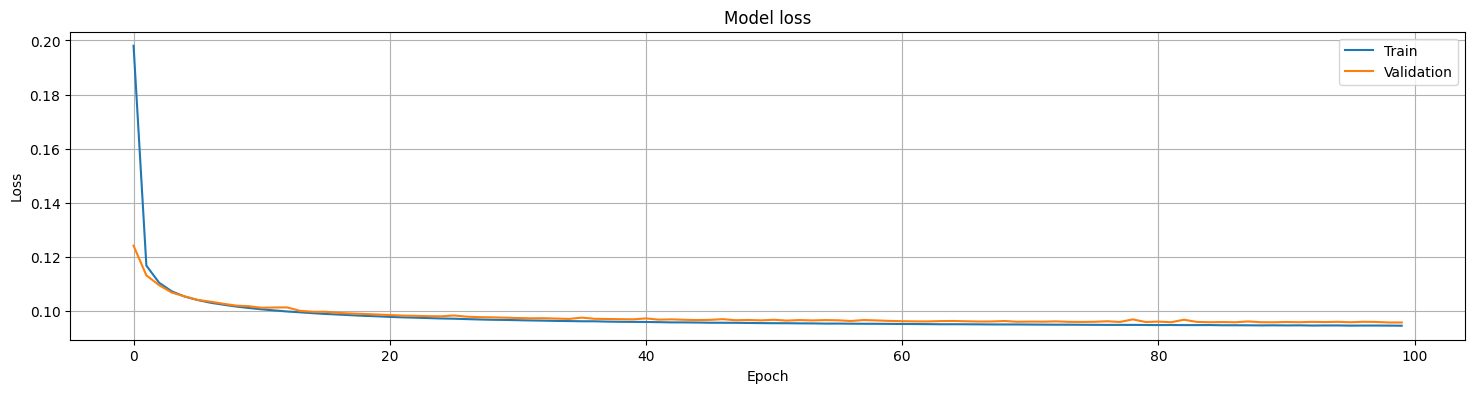

In [ ]:
#Configure the model for training
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')

#Model Training
log = autoencoder1.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, validation_split=0.1)

#Plot loss curves
plot_curve(log)

### 4.4 Display Results

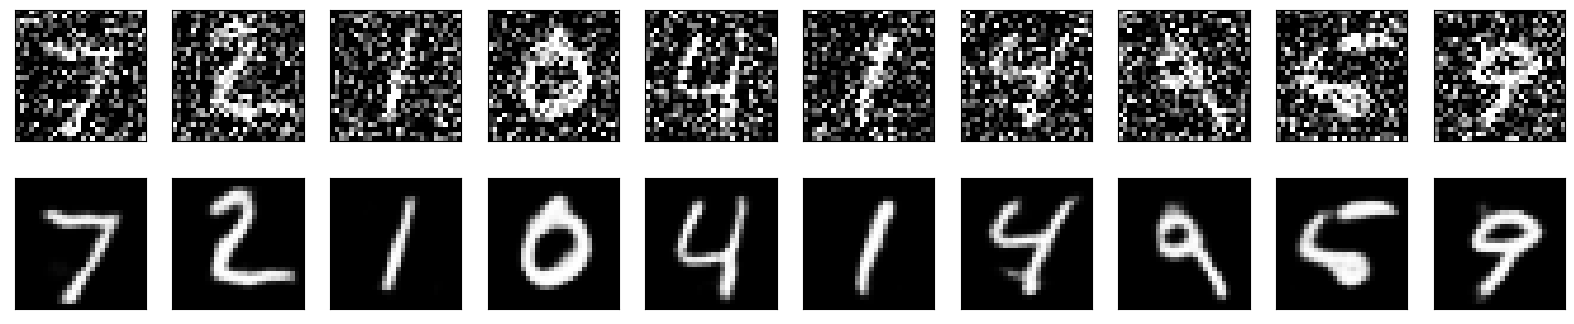

In [ ]:
#Get the encoded values for test images
encoded_img = encoder1(x_test_noisy)

#Get the decoded images from the encoded values
decoded_img = decoder1(encoded_img)

#Plot test and decoded images
denoise_pred(decoded_img.numpy())

## 5. Image Colorization using Autoencoder

### 5.1 Converting CIFAR10 Data to Grayscale

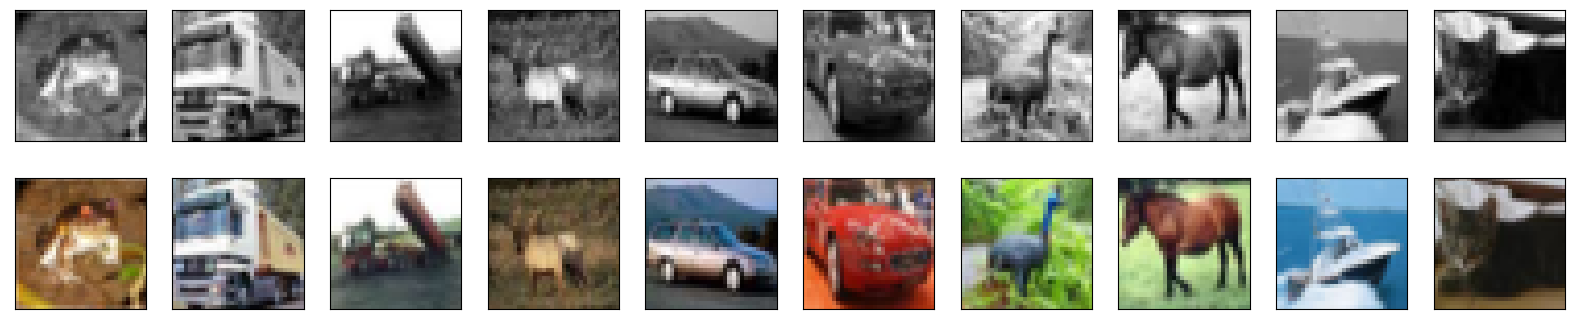

In [ ]:
import numpy as np
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()

def rgb_2_gray(image):
    return np.dot(image[..., :3], [0.299, 0.587, 0.114])

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


x_train_gray = rgb_2_gray(x_train)
x_test_gray = rgb_2_gray(x_test)
x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.
x_train_gray = x_train_gray.reshape((len(x_train), 32,32,1))
x_test_gray = x_test_gray.reshape((len(x_test), 32,32,1))

cifar(x_train_gray, x_train)

### 5.2 Model Definition

In [ ]:
#define encoder network
encoder2 = keras.Sequential(name='Encoder_CNN')
encoder2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32,1), name='E1'))
encoder2.add(layers.MaxPooling2D((2, 2), padding='same', name='E2'))
encoder2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='E3'))
encoder2.add(layers.MaxPooling2D((2, 2), padding='same', name='E4'))
encoder2.summary()

#define decoder network
decoder2 = keras.Sequential(name='Decoder_CNN')
decoder2.add(layers.Conv2DTranspose(32, (3, 3), input_shape=(8,8,32),activation='relu', padding='same',
                                    strides=2, name='D1'))
decoder2.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same',
                                    strides=2, name='D2'))
decoder2.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='Output'))
decoder2.summary()

#define autoencoder by combining encoder and decoder
input_img = keras.Input(shape=(32,32,1), name='Input_Layer')
z = encoder2(input_img)
output_img = decoder2(z)
autoencoder2 = keras.models.Model(inputs=input_img, outputs=output_img, name='Fully_Convolutional_Autoencoder')
autoencoder2.summary()

Model: "Encoder_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 E1 (Conv2D)                 (None, 32, 32, 32)        320       
                                                                 
 E2 (MaxPooling2D)           (None, 16, 16, 32)        0         
                                                                 
 E3 (Conv2D)                 (None, 16, 16, 32)        9248      
                                                                 
 E4 (MaxPooling2D)           (None, 8, 8, 32)          0         
                                                                 
Total params: 9568 (37.38 KB)
Trainable params: 9568 (37.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Decoder_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


### 5.3 Model Training

Epoch 1/100
352/352 [==============================] - 10s 26ms/step - loss: 0.6270 - val_loss: 0.5944
Epoch 2/100
352/352 [==============================] - 9s 26ms/step - loss: 0.5886 - val_loss: 0.5868
Epoch 3/100
352/352 [==============================] - 9s 26ms/step - loss: 0.5835 - val_loss: 0.5850
Epoch 4/100
352/352 [==============================] - 9s 26ms/step - loss: 0.5812 - val_loss: 0.5824
Epoch 5/100
352/352 [==============================] - 9s 26ms/step - loss: 0.5800 - val_loss: 0.5810
Epoch 6/100
352/352 [==============================] - 9s 26ms/step - loss: 0.5791 - val_loss: 0.5802
Epoch 7/100
352/352 [==============================] - 9s 26ms/step - loss: 0.5783 - val_loss: 0.5802
Epoch 8/100
352/352 [==============================] - 9s 26ms/step - loss: 0.5777 - val_loss: 0.5789
Epoch 9/100
352/352 [==============================] - 9s 26ms/step - loss: 0.5771 - val_loss: 0.5790
Epoch 10/100
352/352 [==============================] - 9s 26ms/step - loss: 0.57

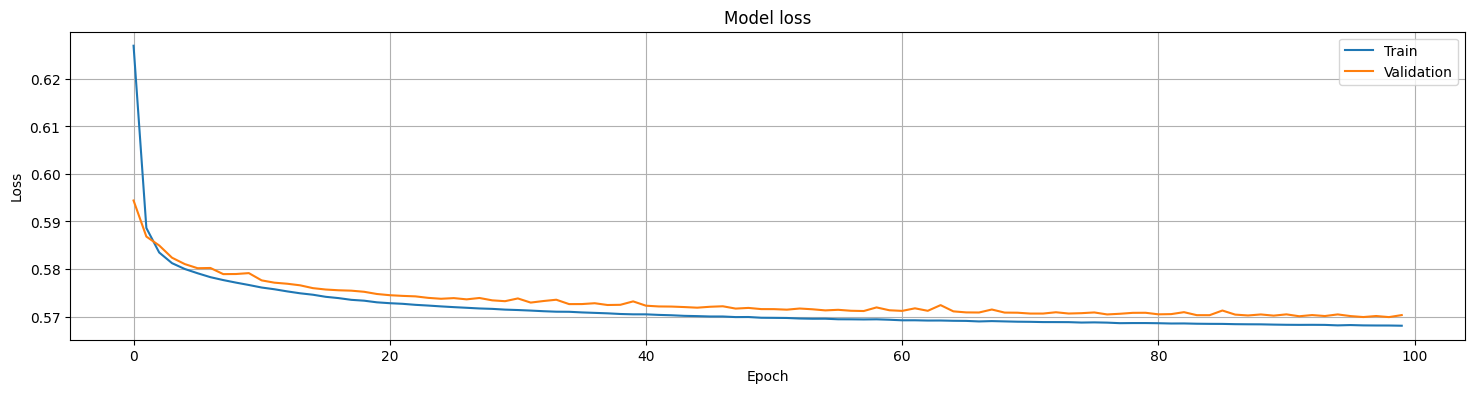

In [ ]:
#Configure the model for training
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

#Model Training
log = autoencoder2.fit(x_train_gray, x_train, epochs=100, batch_size=128, shuffle=True, validation_split=0.1)

#Plot loss curves
plot_curve(log)

### 5.4 Display Results

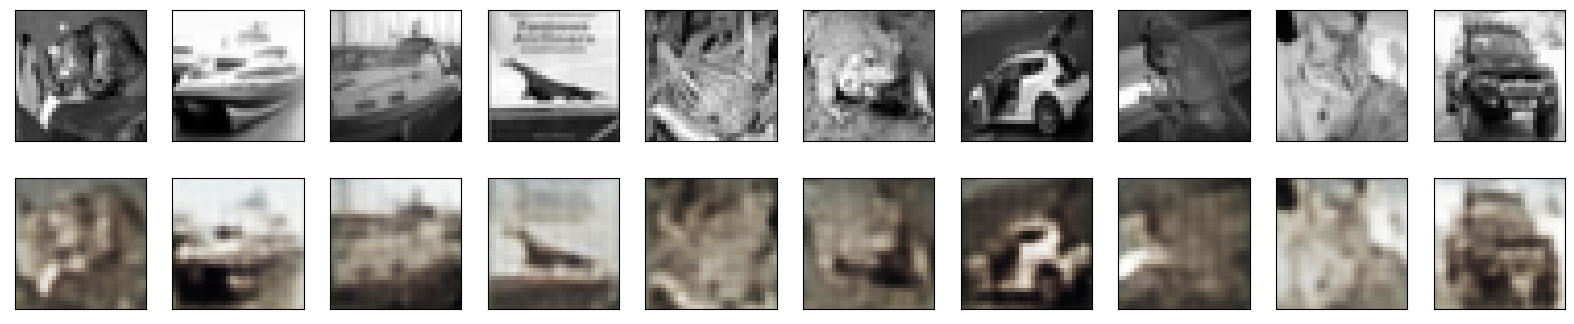

In [ ]:
#Get the encoded values for test images
encoded_img = encoder2(x_test_gray)

#Get the decoded images from the encoded values
decoded_img = decoder2(encoded_img)

#Plot test and decoded images
cifar(x_test_gray,decoded_img)